<a href="https://colab.research.google.com/github/RogerHeederer/DLofAll/blob/master/mnist_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference source : https://github.com/deeplearningzerotoall/PyTorch <br/>
셀프 학습 과정에서 필요한 부분에 대해서는 code, figure 수정, 삽입 등을 수행했습니다..

In [27]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1)
if device == 'cuda':
  torch.cuda.manual_seed_all(1)

In [29]:
#파라미터 세팅
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [30]:
#데이터 세트 준비
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [31]:
#데이터 로드
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [32]:
#신경망 구성 요소 설정
# 레이어 3개 + 배치 노말리제이션 + activation f : relu
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

#레이어 3개
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [40]:
# 모델 만들기 레이어 -> batch -> relu -> 레이어2 -> batch -> relu -> 레이어3
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)

# 레이어 -> relu ->레이어2 -> relu -> 레이어3
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [34]:
## cost function 및 optimizer 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [35]:
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y) # loss 계산
        bn_loss.backward() #backpropagation
        bn_optimizer.step() # weights and bias 재설정

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
       
       
       
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13441(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16983(nn_acc:0.95)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14215(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20274(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.11144(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16785(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12597(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19222(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09689(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.14984(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11777(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18001(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07743(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14053(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09949(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17476(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [36]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
  bn = [i[0] for i in loss_list]
  nn = [i[1] for i in loss_list]

  plt.figure(figsize=(15,10))
  plt.plot(bn, label='With BN')
  plt.plot(nn, label='Without BN')

  if ylim:
    plt.ylim(ylim)

  if title:
    plt.title(title)
  plt.legend()
  plt.grid('on')
  plt.show()

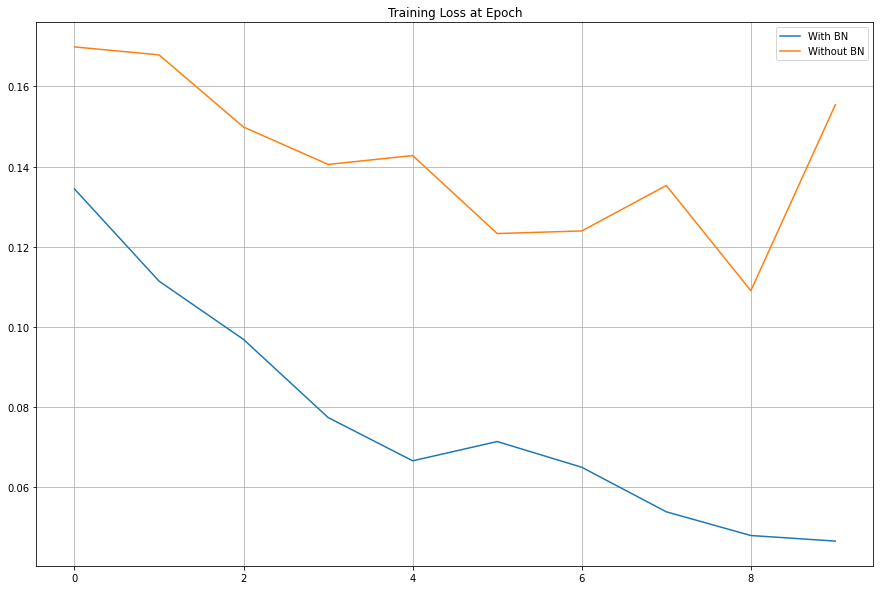

In [37]:
plot_compare(train_losses, title='Training Loss at Epoch')

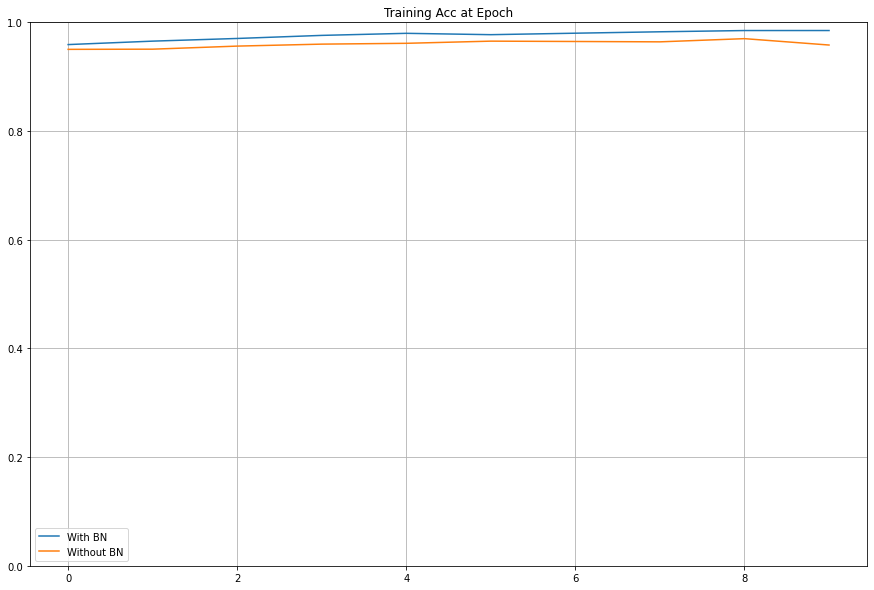

In [38]:
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')

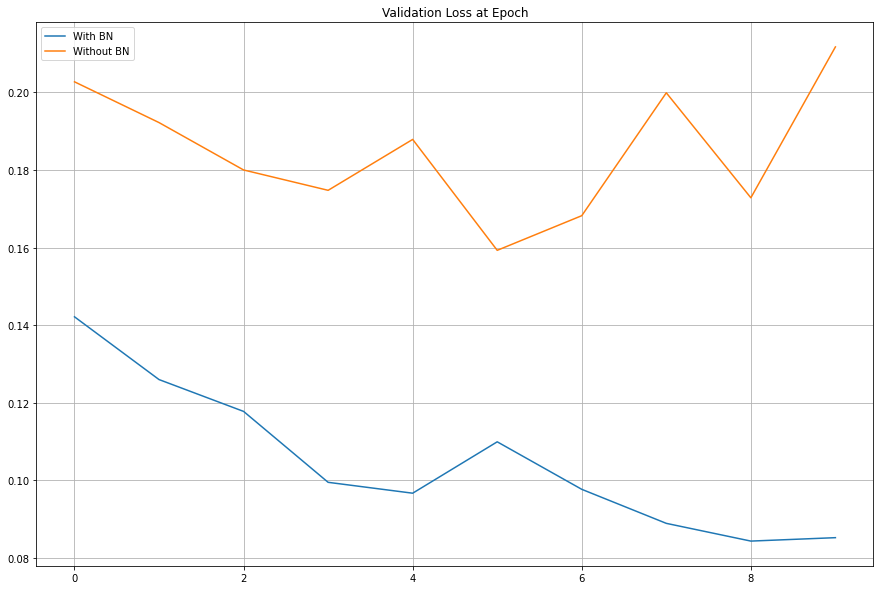

In [39]:
plot_compare(valid_losses, title='Validation Loss at Epoch')

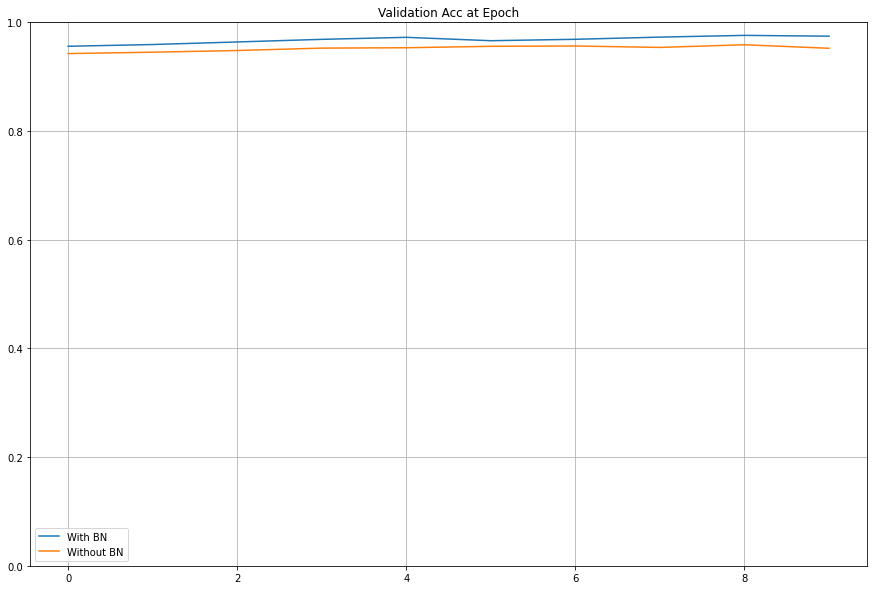

In [41]:
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')